<a href="https://colab.research.google.com/github/KailasVS666/risk-prediction-model/blob/main/risk_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install scikit-learn xgboost shap


In [2]:
from google.colab import files
uploaded = files.upload()

Saving student+performance.zip to student+performance (1).zip


In [4]:
import zipfile

zip_path = "student+performance.zip"
extract_path = "student_performance"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import zipfile, os, pandas as pd

# Step 1: Extract outer zip
outer_zip = "student+performance.zip"
outer_extract = "student_performance"

with zipfile.ZipFile(outer_zip, 'r') as zip_ref:
    zip_ref.extractall(outer_extract)

# Step 2: Extract inner zip
inner_zip = os.path.join(outer_extract, "student.zip")
inner_extract = os.path.join(outer_extract, "student_data")

with zipfile.ZipFile(inner_zip, 'r') as zip_ref:
    zip_ref.extractall(inner_extract)

# Step 3: List files to confirm
print("Files extracted:", os.listdir(inner_extract))

# Step 4: Load dataset
df = pd.read_csv(os.path.join(inner_extract, "student-mat.csv"), sep=";")
df.head()


Files extracted: ['student-merge.R', 'student-por.csv', 'student-mat.csv', 'student.txt']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
# Define risk categories based on final grade (G3)
def categorize_risk(g3):
    if g3 < 10:
        return "High"
    elif g3 < 15:
        return "Medium"
    else:
        return "Low"

df["risk_level"] = df["G3"].apply(categorize_risk)

# Check distribution
print(df["risk_level"].value_counts())
df[["G3", "risk_level"]].head(10)


risk_level
Medium    192
High      130
Low        73
Name: count, dtype: int64


,G3,risk_level
0,6,High
1,6,High
2,10,Medium
3,15,Low
4,10,Medium
5,15,Low
6,11,Medium
7,6,High
8,19,Low
9,15,Low


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# 1. Features and target
X = df.drop(columns=["risk_level", "G1", "G2", "G3"])  # drop grades + target
y = df["risk_level"]

# 2. Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# 3. Preprocessing: OneHot for categoricals, Scale for numerics
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# 4. Build pipeline with RandomForest (baseline model)
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model.fit(X_train, y_train)

# Evaluate on test set
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.50      0.31      0.38        26
         Low       0.43      0.20      0.27        15
      Medium       0.50      0.74      0.60        38

    accuracy                           0.49        79
   macro avg       0.48      0.41      0.42        79
weighted avg       0.49      0.49      0.46        79



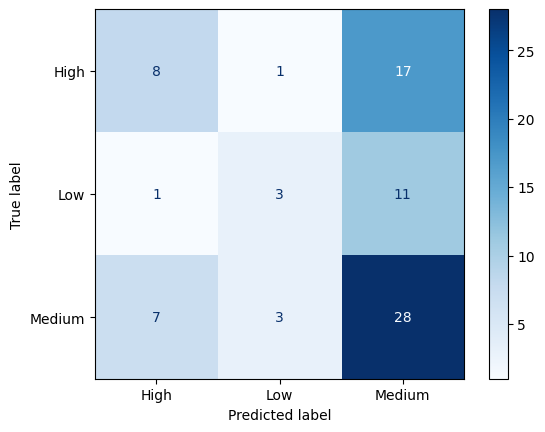

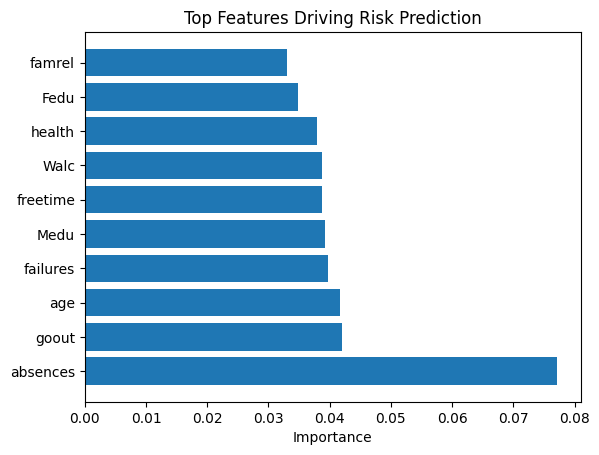

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.show()

# Feature Importance (RandomForest only)
rf = model.named_steps["clf"]
importances = rf.feature_importances_

# Get feature names from preprocessor
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + list(num_cols)

# Plot top features
feat_imp = sorted(zip(importances, all_feature_names), reverse=True)[:10]
scores, names = zip(*feat_imp)

plt.barh(names, scores)
plt.xlabel("Importance")
plt.title("Top Features Driving Risk Prediction")
plt.show()


              precision    recall  f1-score   support

        High       0.60      0.35      0.44        26
         Low       0.25      0.07      0.11        15
      Medium       0.53      0.84      0.65        38

    accuracy                           0.53        79
   macro avg       0.46      0.42      0.40        79
weighted avg       0.50      0.53      0.48        79



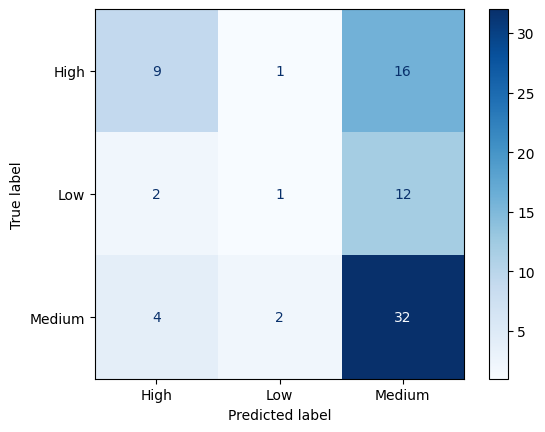

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Rebuild model with class_weight='balanced'
model_balanced = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# Train
model_balanced.fit(X_train, y_train)

# Predict
y_pred_balanced = model_balanced.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model_balanced, X_test, y_test, cmap="Blues")
plt.show()


In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# One-hot encode categorical features
# Using the same preprocessor as before to ensure consistency
X_train_processed = model.named_steps["preprocess"].transform(X_train)
X_test_processed = model.named_steps["preprocess"].transform(X_test)

# Convert to DataFrame to keep column names for SMOTE (optional but helpful)
# Note: Column names after OneHotEncoding will be different
# For SMOTE, we can work directly on the numpy array output from the preprocessor
X_train_processed_df = pd.DataFrame(X_train_processed)


# Encode the target variable
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


# Apply SMOTE on the processed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed_df, y_train_enc)

print("Before SMOTE:", Counter(y_train_enc))
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({np.int64(2): 154, np.int64(0): 104, np.int64(1): 58})
After SMOTE: Counter({np.int64(0): 154, np.int64(2): 154, np.int64(1): 154})


              precision    recall  f1-score   support

        High       0.47      0.27      0.34        26
         Low       0.33      0.27      0.30        15
      Medium       0.52      0.71      0.60        38

    accuracy                           0.48        79
   macro avg       0.44      0.42      0.41        79
weighted avg       0.47      0.48      0.46        79



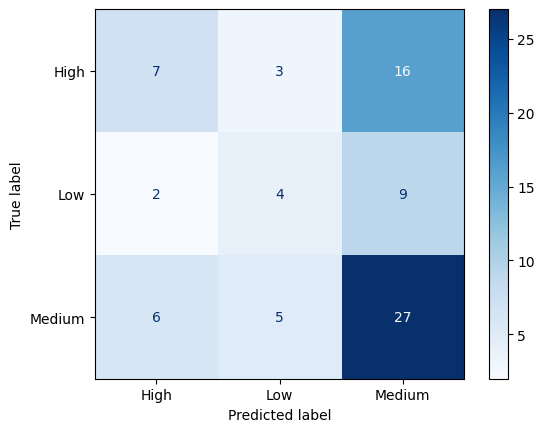

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Rebuild pipeline with XGBoost using the resampled data
# Removed use_label_encoder as it's deprecated
xgb_model_smote = Pipeline([
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    ))
])

# Train on the SMOTE-resampled data
xgb_model_smote.fit(X_train_res, y_train_res)

# Predict on the processed test set (already created in the previous cell)
y_pred_xgb_smote = xgb_model_smote.predict(X_test_processed)

# Decode predictions back to labels using the label encoder 'le'
y_pred_labels_smote = le.inverse_transform(y_pred_xgb_smote)

# Evaluation
print(classification_report(y_test, y_pred_labels_smote))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels_smote, cmap="Blues")
plt.show()

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8}
Best cross-validation weighted F1-score:  0.6338068928823973

Classification Report on Test Set with Best Model:
              precision    recall  f1-score   support

        High       0.39      0.27      0.32        26
         Low       0.33      0.27      0.30        15
      Medium       0.49      0.63      0.55        38

    accuracy                           0.44        79
   macro avg       0.40      0.39      0.39        79
weighted avg       0.43      0.44      0.43        79



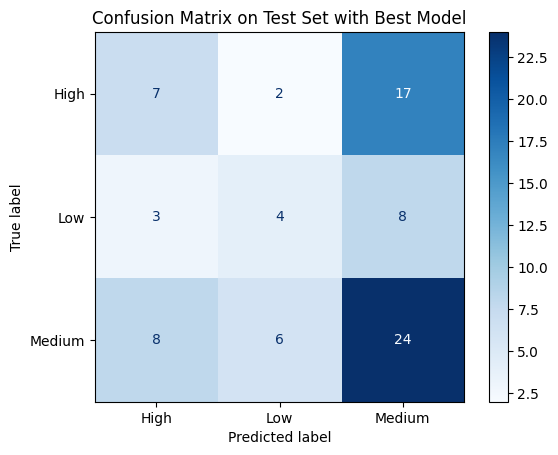

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter distributions for XGBoost for RandomizedSearchCV
param_distributions = {
    'clf__n_estimators': [100, 200, 300, 400, 500], # Added more options
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], # Added more options
    'clf__max_depth': [3, 5, 7, 9], # Added more options
    'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Added more options
    'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Added more options
}

# Create the RandomizedSearchCV object
# We use the xgb_model_smote pipeline defined previously
random_search = RandomizedSearchCV(
    estimator=xgb_model_smote,
    param_distributions=param_distributions,
    n_iter=50, # Reduced number of iterations for faster search
    scoring='f1_weighted',  # Use weighted F1-score for imbalanced data
    cv=3,  # Cross-validation folds
    verbose=1,
    random_state=42, # for reproducibility
    n_jobs=-1 # Use all available cores
)

# Fit the random search to the SMOTE-resampled training data
# Note: RandomizedSearchCV will handle the fitting of the pipeline internally
random_search.fit(X_train_res, y_train_res)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation weighted F1-score: ", random_search.best_score_)

# Evaluate the best model on the original test set
best_xgb_model = random_search.best_estimator_

# Predict on the original test set
# Ensure X_test_processed is used as the input is already preprocessed
y_pred_best_xgb = best_xgb_model.predict(X_test_processed)


# Decode predictions back to labels
y_pred_labels_best_xgb = le.inverse_transform(y_pred_best_xgb)

# Evaluation
print("\nClassification Report on Test Set with Best Model:")
print(classification_report(y_test, y_pred_labels_best_xgb))

# Confusion matrix for the best model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels_best_xgb, cmap="Blues")
plt.title("Confusion Matrix on Test Set with Best Model")
plt.show()

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features (excluding G1, G2, G3, and the target) and target
X_early = df.drop(columns=["risk_level", "G1", "G2", "G3"])
y_early = df["risk_level"]

# Identify categorical and numeric columns
cat_cols_early = X_early.select_dtypes(include=["object"]).columns
num_cols_early = X_early.select_dtypes(exclude=["object"]).columns

# Preprocessing: OneHot for categoricals, Scale for numerics
preprocessor_early = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_early),
    ("num", StandardScaler(), num_cols_early)
])

# Build pipeline with Gradient Boosting Classifier
early_warning_model = Pipeline([
    ("preprocess", preprocessor_early),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# Split dataset (using the same stratification as before)
X_train_early, X_test_early, y_train_early, y_test_early = train_test_split(
    X_early, y_early, test_size=0.2, random_state=42, stratify=y_early
)

# Train model
early_warning_model.fit(X_train_early, y_train_early)

print("Early-Warning Model Training Complete.")

Early-Warning Model Training Complete.


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features (including G1 and G2) and target
X_end_course = df.drop(columns=["risk_level", "G3"])
y_end_course = df["risk_level"]

# Identify categorical and numeric columns
cat_cols_end_course = X_end_course.select_dtypes(include=["object"]).columns
num_cols_end_course = X_end_course.select_dtypes(exclude=["object"]).columns

# Preprocessing: OneHot for categoricals, Scale for numerics
preprocessor_end_course = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_end_course),
    ("num", StandardScaler(), num_cols_end_course)
])

# Build pipeline with Gradient Boosting Classifier
end_course_model = Pipeline([
    ("preprocess", preprocessor_end_course),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# Split dataset
X_train_end_course, X_test_end_course, y_train_end_course, y_test_end_course = train_test_split(
    X_end_course, y_end_course, test_size=0.2, random_state=42, stratify=y_end_course
)

# Train model
end_course_model.fit(X_train_end_course, y_train_end_course)

print("End-of-Course Model Training Complete.")


End-of-Course Model Training Complete.


End-of-Course Model Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.88      0.87        26
         Low       1.00      0.93      0.97        15
      Medium       0.89      0.89      0.89        38

    accuracy                           0.90        79
   macro avg       0.92      0.90      0.91        79
weighted avg       0.90      0.90      0.90        79



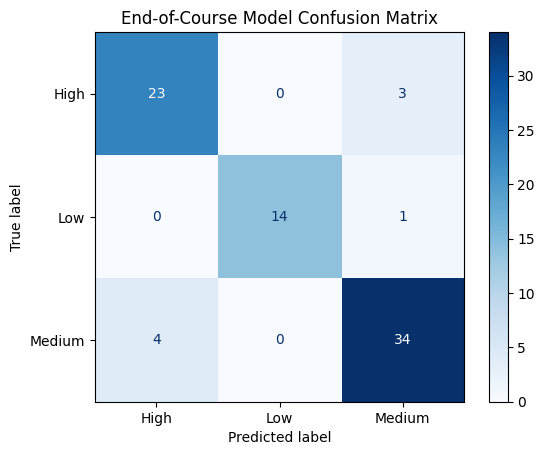


End-of-Course Model ROC AUC (High Risk vs Rest): 0.9746


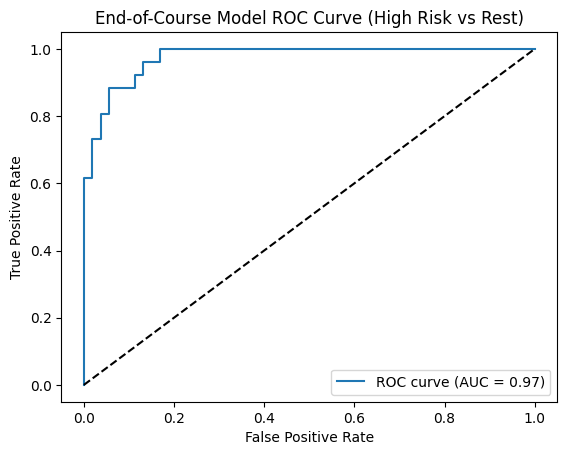


Optimal Threshold for High Risk (maximizing F2) - End-of-Course Model: 0.0618
Best F2 Score for High Risk at optimal threshold - End-of-Course Model: 0.9353

Classification Report with Optimal Threshold (0.0618) for High Risk - End-of-Course Model:
               precision    recall  f1-score   support

Not High Risk       0.74      1.00      0.85        26
         High       1.00      0.83      0.91        53

     accuracy                           0.89        79
    macro avg       0.87      0.92      0.88        79
 weighted avg       0.92      0.89      0.89        79



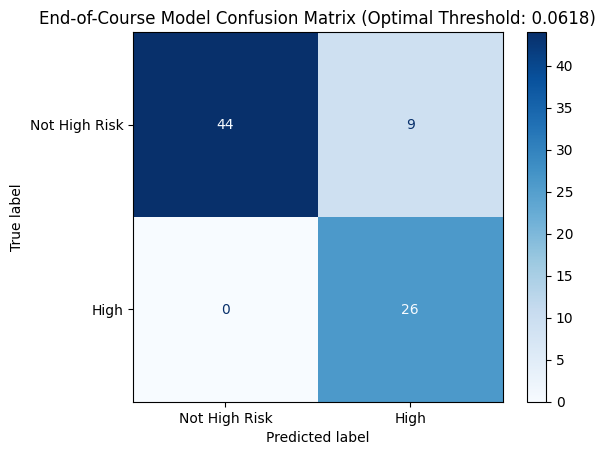

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Evaluate the End-of-Course Model
y_pred_end_course = end_course_model.predict(X_test_end_course)
y_prob_end_course = end_course_model.predict_proba(X_test_end_course)[:, 1] # Probability of the positive class (High Risk)


# Classification Report
print("End-of-Course Model Classification Report:")
print(classification_report(y_test_end_course, y_pred_end_course))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(end_course_model, X_test_end_course, y_test_end_course, cmap="Blues")
plt.title("End-of-Course Model Confusion Matrix")
plt.show()

# ROC AUC
# Need to handle multi-class for AUC, or focus on one class vs rest
# Let's calculate AUC for 'High' risk vs rest
lb = LabelBinarizer()
y_test_end_course_binary = lb.fit_transform(y_test_end_course)
high_risk_class_index_end_course = list(lb.classes_).index('High')

# Get probabilities for the 'High' class
y_prob_end_course_high = end_course_model.predict_proba(X_test_end_course)[:, high_risk_class_index_end_course]

# Calculate ROC AUC for 'High' class
roc_auc_end_course = roc_auc_score(y_test_end_course_binary[:, high_risk_class_index_end_course], y_prob_end_course_high)
print(f"\nEnd-of-Course Model ROC AUC (High Risk vs Rest): {roc_auc_end_course:.4f}")

# Plot ROC curve
fpr_end_course, tpr_end_course, thresholds_end_course = roc_curve(y_test_end_course_binary[:, high_risk_class_index_end_course], y_prob_end_course_high)
plt.plot(fpr_end_course, tpr_end_course, label=f'ROC curve (AUC = {roc_auc_end_course:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('End-of-Course Model ROC Curve (High Risk vs Rest)')
plt.legend(loc="lower right")
plt.show()


# Threshold Tuning to Maximize F2 Score for High Risk
from sklearn.metrics import fbeta_score

# Find the optimal threshold
best_threshold_end_course = 0
best_f2_score_end_course = 0

# Iterate through possible thresholds (using probabilities from the 'High' class)
# We can use the probabilities themselves as potential thresholds
for threshold_end_course in np.sort(y_prob_end_course_high):
    y_pred_threshold_end_course = (y_prob_end_course_high >= threshold_end_course).astype(int)
    # Need to convert y_test_end_course to binary for the 'High' class for fbeta_score
    f2_end_course = fbeta_score(y_test_end_course_binary[:, high_risk_class_index_end_course], y_pred_threshold_end_course, beta=2)

    if f2_end_course > best_f2_score_end_course:
        best_f2_score_end_course = f2_end_course
        best_threshold_end_course = threshold_end_course

print(f"\nOptimal Threshold for High Risk (maximizing F2) - End-of-Course Model: {best_threshold_end_course:.4f}")
print(f"Best F2 Score for High Risk at optimal threshold - End-of-Course Model: {best_f2_score_end_course:.4f}")

# Evaluate with the optimal threshold
y_pred_optimal_threshold_end_course = (y_prob_end_course_high >= best_threshold_end_course).astype(int)

# Convert predictions back to original labels for classification report (optional, but good for clarity)
# This mapping assumes 0 is not High Risk and 1 is High Risk in the binary representation
# Check the order of classes in lb.classes_
predicted_labels_optimal_end_course = ['High' if pred == 1 else 'Not High Risk' for pred in y_pred_optimal_threshold_end_course]
actual_labels_binary_end_course = ['High' if actual == 1 else 'Not High Risk' for actual in y_test_end_course_binary[:, high_risk_class_index_end_course]]


print(f"\nClassification Report with Optimal Threshold ({best_threshold_end_course:.4f}) for High Risk - End-of-Course Model:")
# Need to ensure consistent labels in classification_report
# Let's use binary labels for classification report with tuned threshold for clarity
print(classification_report(actual_labels_binary_end_course, predicted_labels_optimal_end_course, target_names=['Not High Risk', 'High']))

# Confusion matrix with the optimal threshold for High Risk
# Need to generate predictions based on the optimal threshold
y_pred_optimal_high_binary_end_course = (y_prob_end_course_high >= best_threshold_end_course).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test_end_course_binary[:, high_risk_class_index_end_course], y_pred_optimal_high_binary_end_course, cmap="Blues", display_labels=['Not High Risk', 'High'])
plt.title(f"End-of-Course Model Confusion Matrix (Optimal Threshold: {best_threshold_end_course:.4f})")
plt.show()

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features (excluding only G3 and the target) and target for the end-of-course model
X_end_course = df.drop(columns=["risk_level", "G3"])
y_end_course = df["risk_level"]

# Identify categorical and numeric columns (G1 and G2 are now included in numeric)
cat_cols_end_course = X_end_course.select_dtypes(include=["object"]).columns
num_cols_end_course = X_end_course.select_dtypes(exclude=["object"]).columns

# Preprocessing: OneHot for categoricals, Scale for numerics
preprocessor_end_course = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_end_course),
    ("num", StandardScaler(), num_cols_end_course)
])

# Build pipeline with Gradient Boosting Classifier
end_course_model = Pipeline([
    ("preprocess", preprocessor_end_course),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# Split dataset (using the same stratification as before)
X_train_end_course, X_test_end_course, y_train_end_course, y_test_end_course = train_test_split(
    X_end_course, y_end_course, test_size=0.2, random_state=42, stratify=y_end_course
)

# Train model
end_course_model.fit(X_train_end_course, y_train_end_course)

print("End-of-Course Model Training Complete.")

End-of-Course Model Training Complete.


Early-Warning Model Classification Report (Default Threshold):
              precision    recall  f1-score   support

        High       0.44      0.31      0.36        26
         Low       0.30      0.20      0.24        15
      Medium       0.53      0.71      0.61        38

    accuracy                           0.48        79
   macro avg       0.42      0.41      0.40        79
weighted avg       0.46      0.48      0.46        79



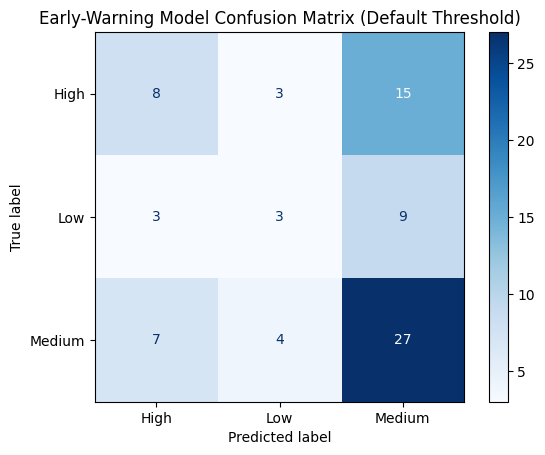


Early-Warning Model ROC AUC (High Risk vs Rest): 0.5929


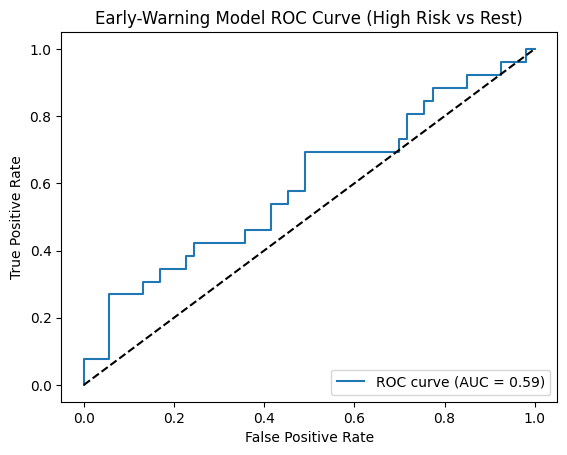


Optimal Threshold for High Risk (maximizing F2): 0.0434
Best F2 Score for High Risk at optimal threshold: 0.7143

Classification Report with Optimal Threshold (0.0434) for High Risk:
               precision    recall  f1-score   support

Not High Risk       1.00      0.02      0.04        53
         High       0.33      1.00      0.50        26

     accuracy                           0.34        79
    macro avg       0.67      0.51      0.27        79
 weighted avg       0.78      0.34      0.19        79



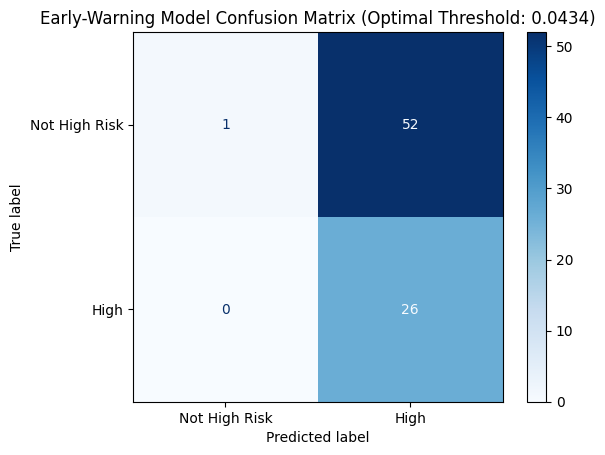

In [20]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the Early-Warning Model
y_pred_early = early_warning_model.predict(X_test_early)
y_prob_early = early_warning_model.predict_proba(X_test_early)[:, 1] # Probability of the positive class (High Risk)

# Classification Report
print("Early-Warning Model Classification Report (Default Threshold):")
print(classification_report(y_test_early, y_pred_early))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(early_warning_model, X_test_early, y_test_early, cmap="Blues")
plt.title("Early-Warning Model Confusion Matrix (Default Threshold)")
plt.show()

# ROC AUC
# Need to handle multi-class for AUC, or focus on one class vs rest
# Let's calculate AUC for 'High' risk vs rest
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_early_binary = lb.fit_transform(y_test_early)
high_risk_class_index = list(lb.classes_).index('High')

# Get probabilities for the 'High' class
y_prob_early_high = early_warning_model.predict_proba(X_test_early)[:, high_risk_class_index]

# Calculate ROC AUC for 'High' class
roc_auc_early = roc_auc_score(y_test_early_binary[:, high_risk_class_index], y_prob_early_high)
print(f"\nEarly-Warning Model ROC AUC (High Risk vs Rest): {roc_auc_early:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_early_binary[:, high_risk_class_index], y_prob_early_high)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_early:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Early-Warning Model ROC Curve (High Risk vs Rest)')
plt.legend(loc="lower right")
plt.show()

# Threshold Tuning to Maximize F2 Score for High Risk
from sklearn.metrics import fbeta_score

# Find the optimal threshold
best_threshold = 0
best_f2_score = 0

# Iterate through possible thresholds (using probabilities from the 'High' class)
# We can use the probabilities themselves as potential thresholds
for threshold in np.sort(y_prob_early_high):
    y_pred_threshold = (y_prob_early_high >= threshold).astype(int)
    # Need to convert y_test_early to binary for the 'High' class for fbeta_score
    f2 = fbeta_score(y_test_early_binary[:, high_risk_class_index], y_pred_threshold, beta=2, zero_division=0)

    if f2 > best_f2_score:
        best_f2_score = f2
        best_threshold = threshold

print(f"\nOptimal Threshold for High Risk (maximizing F2): {best_threshold:.4f}")
print(f"Best F2 Score for High Risk at optimal threshold: {best_f2_score:.4f}")

# Evaluate with the optimal threshold for High Risk
y_pred_optimal_high_binary = (y_prob_early_high >= best_threshold).astype(int)

# Ensure true labels are also binary for the 'High' class for comparison
y_true_high_binary = y_test_early_binary[:, high_risk_class_index]

print(f"\nClassification Report with Optimal Threshold ({best_threshold:.4f}) for High Risk:")
# Use the binary true and predicted labels for the classification report
print(classification_report(y_true_high_binary, y_pred_optimal_high_binary, target_names=['Not High Risk', 'High'], zero_division=0))

# Confusion matrix with the optimal threshold for High Risk
ConfusionMatrixDisplay.from_predictions(y_true_high_binary, y_pred_optimal_high_binary, cmap="Blues", display_labels=['Not High Risk', 'High'])
plt.title(f"Early-Warning Model Confusion Matrix (Optimal Threshold: {best_threshold:.4f})")
plt.show()

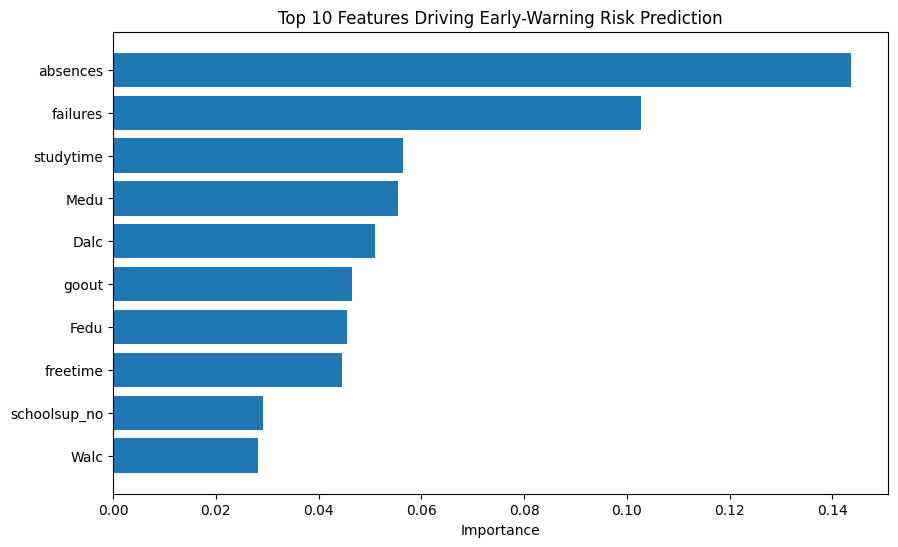

In [21]:
import matplotlib.pyplot as plt

# Get the trained Gradient Boosting Classifier from the pipeline
gb_model = early_warning_model.named_steps["clf"]
importances_early = gb_model.feature_importances_

# Get feature names from the preprocessor
# The preprocessor has two transformers: 'cat' (OneHotEncoder) and 'num' (StandardScaler)
preprocessor = early_warning_model.named_steps["preprocess"]

# Get feature names from the OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names_early = ohe.get_feature_names_out(cat_cols_early)

# Get feature names from the StandardScaler (these are the original numeric column names)
num_feature_names_early = num_cols_early.tolist()

# Combine all feature names
all_feature_names_early = list(cat_feature_names_early) + num_feature_names_early

# Create a list of (importance, feature_name) tuples
feat_imp_early = sorted(zip(importances_early, all_feature_names_early), reverse=True)

# Select the top 10 features for plotting (or adjust as needed)
top_n = 10
top_feat_imp_early = feat_imp_early[:top_n]

scores_early, names_early = zip(*top_feat_imp_early)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(names_early, scores_early)
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features Driving Early-Warning Risk Prediction")
plt.gca().invert_yaxis() # Put the most important feature at the top
plt.show()

In [22]:
import joblib
import os

# Define file paths for saving the models
early_warning_model_path = "early_warning_model_pipeline.joblib"
end_course_model_path = "end_course_model_pipeline.joblib"

# Save the early-warning model pipeline
joblib.dump(early_warning_model, early_warning_model_path)
print(f"Early-warning model pipeline saved to {early_warning_model_path}")

# Save the end-of-course model pipeline
joblib.dump(end_course_model, end_course_model_path)
print(f"End-of-course model pipeline saved to {end_course_model_path}")

# Verify the files are saved (optional)
print("\nSaved files:")
print(os.listdir())

Early-warning model pipeline saved to early_warning_model_pipeline.joblib
End-of-course model pipeline saved to end_course_model_pipeline.joblib

Saved files:
['.config', 'student_performance', 'student+performance (1).zip', 'Screenshot 2025-09-09 135929.png', 'end_course_model_pipeline.joblib', 'student-mat.csv', 'early_warning_model_pipeline.joblib', 'student+performance.zip', 'sample_data']


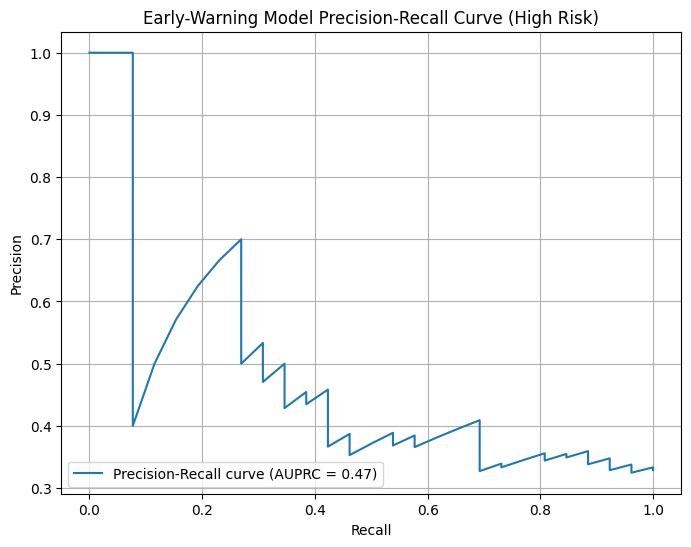

Area Under the Precision-Recall Curve (AUPRC): 0.4690


In [23]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision and recall for different thresholds
precision, recall, thresholds_pr = precision_recall_curve(y_true_high_binary, y_prob_early_high)

# Calculate the Area Under the Precision-Recall Curve (AUPRC)
auprc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Early-Warning Model Precision-Recall Curve (High Risk)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.4f}")

Classification Report with New Threshold (0.1500) for High Risk:
               precision    recall  f1-score   support

Not High Risk       0.70      0.36      0.47        53
         High       0.35      0.69      0.46        26

     accuracy                           0.47        79
    macro avg       0.52      0.53      0.47        79
 weighted avg       0.59      0.47      0.47        79



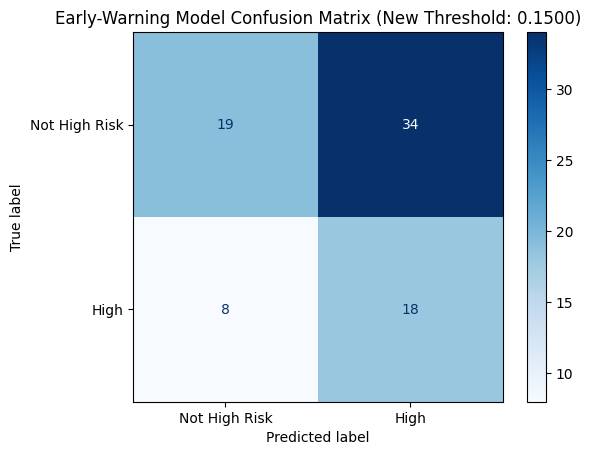

In [24]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the new threshold based on the Precision-Recall curve analysis
new_threshold = 0.15

# Get the binary true labels for High Risk (1 for High Risk, 0 for Not High Risk)
# This was created in a previous cell (4e01e5a4)
# Make sure y_true_high_binary and y_prob_early_high are available from previous execution
# If not, re-run the cell that generated them or ensure they are in the current kernel state.

# Generate binary predictions using the new threshold
y_pred_new_threshold_binary = (y_prob_early_high >= new_threshold).astype(int)

# Use the binary true and predicted labels for the classification report
print(f"Classification Report with New Threshold ({new_threshold:.4f}) for High Risk:")
print(classification_report(y_true_high_binary, y_pred_new_threshold_binary, target_names=['Not High Risk', 'High'], zero_division=0))

# Confusion matrix with the new threshold for High Risk
ConfusionMatrixDisplay.from_predictions(y_true_high_binary, y_pred_new_threshold_binary, cmap="Blues", display_labels=['Not High Risk', 'High'])
plt.title(f"Early-Warning Model Confusion Matrix (New Threshold: {new_threshold:.4f})")
plt.show()

In [26]:
import joblib
import pandas as pd
import numpy as np

# 1. Load the saved model pipeline
loaded_early_warning_model = joblib.load('early_warning_model_pipeline.joblib')
print("Early-Warning Model pipeline loaded successfully.")

# 2. Create sample new student data
# We need to create a DataFrame with the same columns as X_early used for training
# You would replace these values with actual data for a new student
sample_new_student_data = pd.DataFrame({
    'school': ['GP'],
    'sex': ['F'],
    'age': [16],
    'address': ['U'],
    'famsize': ['GT3'],
    'Pstatus': ['T'],
    'Medu': [4],
    'Fedu': [4],
    'Mjob': ['teacher'],
    'Fjob': ['other'],
    'reason': ['course'],
    'guardian': ['mother'],
    'traveltime': [2],
    'studytime': [2],
    'failures': [0],
    'schoolsup': ['yes'],
    'famsup': ['no'],
    'paid': ['no'],
    'activities': ['no'],
    'nursery': ['yes'],
    'higher': ['yes'],
    'internet': ['no'],
    'romantic': ['no'],
    'famrel': [4],
    'freetime': [3],
    'goout': [4],
    'Dalc': [1],
    'Walc': [1],
    'health': [3],
    'absences': [6]
}, index=[0]) # Use index=[0] for a single row DataFrame

# Ensure the columns are in the same order as the training data (optional but good practice)
# Get the original column names from X_early (assuming X_early is still in the environment)
# If X_early is not available, you would need to load it or have a predefined list of columns
if 'X_early' in locals():
    original_cols = X_early.columns
    sample_new_student_data = sample_new_student_data[original_cols]
else:
    print("Warning: X_early not found. Skipping column order check. Ensure new data columns match training data.")
    # If X_early is not available, you would need to define original_cols manually
    # original_cols = ['school', 'sex', 'age', ...]


# 3. Make predictions using the loaded pipeline
predicted_category = loaded_early_warning_model.predict(sample_new_student_data)
predicted_probability_high_risk = loaded_early_warning_model.predict_proba(sample_new_student_data)[:, list(loaded_early_warning_model.classes_).index('High')] # Get probability for 'High' class

print(f"\nPredicted risk category (default threshold): {predicted_category[0]}")
print(f"Predicted probability of being High Risk: {predicted_probability_high_risk[0]:.4f}")

# Apply the new threshold (0.15) for a binary prediction based on our adjusted balance
new_threshold = 0.15 # Use the threshold we decided on
predicted_high_risk_binary = (predicted_probability_high_risk >= new_threshold).astype(int)

# Map the binary prediction back to labels for clarity (assuming 1 is High, 0 is Not High Risk)
predicted_label_new_threshold = 'High' if predicted_high_risk_binary[0] == 1 else 'Not High Risk'

print(f"Predicted risk category (with threshold {new_threshold:.2f}): {predicted_label_new_threshold}")

Early-Warning Model pipeline loaded successfully.

Predicted risk category (default threshold): High
Predicted probability of being High Risk: 0.4930
Predicted risk category (with threshold 0.15): High


In [27]:
import pandas as pd

# Get the binary true labels for High Risk (1 for High Risk, 0 for Not High Risk)
# This was created in the previous cell (4e01e5a4)
y_true_high_binary = y_test_early_binary[:, high_risk_class_index]

# Get the binary predictions from the Early-Warning model with the optimal threshold
y_pred_optimal_high_binary = (y_prob_early_high >= best_threshold).astype(int)

# Identify false positives: Predicted as High Risk (1) but actually Not High Risk (0)
false_positives_indices = X_test_early.index[(y_pred_optimal_high_binary == 1) & (y_true_high_binary == 0)]

# Extract the features of these false positives
false_positives_features = X_test_early.loc[false_positives_indices]

print(f"Number of False Positives: {len(false_positives_features)}")
print("\nFeatures of False Positives:")
display(false_positives_features)

Number of False Positives: 52

Features of False Positives:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
171,GP,M,16,U,GT3,T,1,0,other,other,...,yes,yes,yes,4,3,2,1,1,3,2
6,GP,M,16,U,LE3,T,2,2,other,other,...,yes,yes,no,4,4,4,1,1,3,0
8,GP,M,15,U,LE3,A,3,2,services,other,...,yes,yes,no,4,2,2,1,1,1,0
298,GP,F,18,U,GT3,T,4,3,other,other,...,yes,yes,no,4,3,3,1,1,3,0
26,GP,M,15,U,GT3,T,2,2,other,other,...,yes,yes,no,4,2,2,1,2,5,2
266,GP,M,17,U,GT3,T,3,1,services,other,...,yes,yes,yes,5,4,4,3,4,5,2
199,GP,F,16,U,LE3,T,4,4,teacher,teacher,...,yes,yes,no,4,5,2,1,2,3,0
371,MS,M,18,R,LE3,T,1,2,at_home,services,...,no,yes,yes,4,3,3,2,3,3,3
222,GP,F,16,U,GT3,T,2,3,services,teacher,...,yes,yes,no,2,3,1,1,1,3,2
198,GP,F,17,U,GT3,T,4,4,services,teacher,...,yes,yes,no,4,2,4,2,3,2,24


              precision    recall  f1-score   support

        High       0.44      0.31      0.36        26
         Low       0.30      0.20      0.24        15
      Medium       0.53      0.71      0.61        38

    accuracy                           0.48        79
   macro avg       0.42      0.41      0.40        79
weighted avg       0.46      0.48      0.46        79



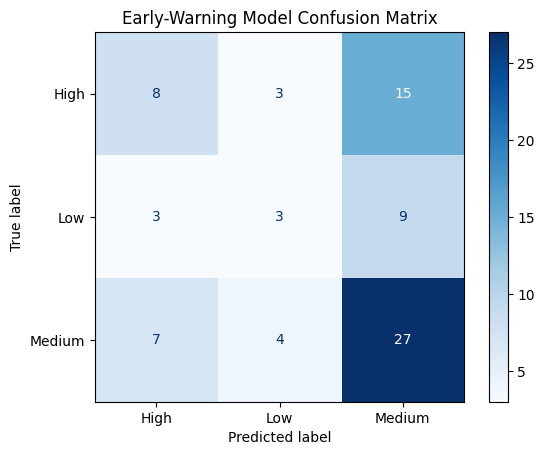

In [28]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_early = early_warning_model.predict(X_test_early)

# Evaluate the model
print(classification_report(y_test_early, y_pred_early))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(early_warning_model, X_test_early, y_test_early, cmap="Blues")
plt.title("Early-Warning Model Confusion Matrix")
plt.show()